In [1]:
%matplotlib inline
from collections import OrderedDict
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotting as mplt
import seaborn as sns
import sys

pkg_dir = '/home/mrossol/NaTGenPD'
#pkg_dir = '..'
sys.path.append(pkg_dir)
import NaTGenPD as npd
import NaTGenPD.cluster as cluster
from NaTGenPD.analysis import ProcedureAnalysis, QuartileAnalysis

# Plotting settings
sns.set_style("white")
sns.set_style("ticks")
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42


def get_hr_fit(group_fits, unit_id):
    unit_fit = group_fits.loc[group_fits['unit_id'] == unit_id]
    cols = ['load_min', 'load_2', 'load_3', 'load_4', 'load_max']
    load = unit_fit[cols].values
    hr = unit_fit[['heat_rate({})'.format(c) for c in cols]].values
    
    return np.dstack((load, hr))[0]
    

def get_raw_cc(raw_group, unit_id):
    pos = raw_group.df['cc_unit'] == unit_id
    cc_unit = raw_group.df.loc[pos]
    cc_unit = cc_unit.groupby('time')[['load', 'HTINPUT']].sum()
    cc_unit = cc_unit.reset_index()

    cc_unit['heat_rate'] = cc_unit['HTINPUT'] / cc_unit['load']
    return cc_unit[['load', 'heat_rate']].values

    
def lighten(color, perc):
    color = [min(c + (1 * perc) , 1) for c in color]
    return color

def darken(color, perc):
    color = [max(c - (1 * perc) , 0) for c in color]
    return color


data_dir = '/scratch/mrossol/CEMS'
#data_dir = '/Users/mrossol/Downloads/CEMS'
out_dir = os.path.join(data_dir, 'analysis')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

fig_dir = os.path.join(out_dir, 'Figures')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

/home/mrossol/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fits_dir = os.path.join(data_dir, 'Final_Fits')
raw_paths = [os.path.join(data_dir, '{y}/SMOKE_{y}.h5'.format(y=y))
            for y in (2016, 2017)]
clean_path = os.path.join(data_dir, 'SMOKE_Clean_2016-2017.h5')
filter_path = os.path.join(data_dir, 'SMOKE_Filtered_2016-2017.h5')


analysis = ProcedureAnalysis(fits_dir, raw_paths, clean_path, filter_path)

# Dev

In [ ]:
def plot_unit(unit_id, raw_df, filtered_df, group_fits, out_dir=None, title=None):
    if out_dir is not None:
        showplot=False
        fig_dir = os.path.join(out_dir, unit_id)
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    else:
        showplot=True
    
    raw_unit = raw_df[unit_id][['load', 'heat_rate']].values
    filtered_unit = filtered_df[unit_id]
    pos = filtered_unit['cluster'] >= 0
    clean_unit = filtered_unit[['load', 'heat_rate']].values
    final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values

    x = raw_unit[:, 0]
    x_lim = np.nanmax(x[x != np.inf]) * 1.1
    y = raw_unit[:, 1]
    y_lim = np.nanmax(y[y != np.inf]) * 1.1
    if out_dir is not None:
        f_path = "{}-rcf.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    mplt.line_plot(raw_unit, clean_unit, final_unit, despine=True,
                   title=title, suptitle=unit_id,
                   linestyles=('', ), markers=('o', ),
                   colors=mplt.get_COLORS(('orange', 'purple', 'cyan')),
                   xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
                   xlim=(0, x_lim), ylim=(0, y_lim),
                   filename=f_path, showplot=showplot
              )

    if out_dir is not None:
        f_path = "{}-rhist.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    density_plot(raw_unit[:, 0], despine=True,
                 title=title, suptitle=unit_id,
                 bins=100, kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'red',
                                                'linewidth': 0.5,
                                                "rwidth":None},
                 colors=mplt.get_COLORS(('orange',)),
                 xlabel='Load (MWh)', ylabel='Counts',
                 xlim=(0, x_lim),
                 filename=f_path, showplot=showplot
                )

    x = clean_unit[:, 0]
    x_lim = np.nanmax(x[x != np.inf]) * 1.1
    y = clean_unit[:, 1]
    y_lim = np.nanmax(y[y != np.inf]) * 1.1
    if out_dir is not None:
        f_path = "{}-rcf2.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    mplt.line_plot(raw_unit, clean_unit, final_unit, despine=True,
                   linestyles=('', ), markers=('o', ),
                   colors=mplt.get_COLORS(('orange', 'purple', 'cyan')),
                   xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
                   xlim=(0, x_lim), ylim=(0, y_lim),
                   filename=f_path, showplot=showplot
              )

    if out_dir is not None:
        f_path = "{}-hist.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    density_plot(clean_unit[:, 0], final_unit[:, 0], despine=True,
                 title=title, suptitle=unit_id,
                 bins=100, kde=False, hist_kws={'alpha': 1.0,
                                                'edgecolor':'black',
                                                'linewidth': 0.5,
                                                "rwidth":None},
                 colors=mplt.get_COLORS(('purple', 'cyan')),
                 xlabel='Load (MWh)', ylabel='Counts',
                 xlim=(0, x_lim),
                 filename=f_path, showplot=showplot
                )

    if out_dir is not None:
        f_path = "{}-fit.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    unit_fit = get_hr_fit(group_fits, unit_id)
    x = final_unit[:, 0]
    x_lim = np.nanmax(x[x != np.inf]) * 1.1
    y = final_unit[:, 1]
    y_lim = np.nanmax(y[y != np.inf]) * 1.1
    mplt.line_plot(final_unit, unit_fit, despine=True,
                   linestyles=('', '--'), markers=('o',),
                   colors=mplt.get_COLORS(('cyan', 'red')),
                   xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
                   xlim=(0, x_lim), ylim=(0, y_lim),
                   filename=f_path, showplot=showplot
              )

    
def plot_CC(unit_id, raw_df, filtered_df, group_fits, out_dir=None, color_shift=0.25):
    if out_dir is not None:
        showplot=False
        fig_dir = os.path.join(out_dir, unit_id)
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    else:
        showplot=True
    
    raw_unit = get_raw_cc(raw_df, unit_id)
    filtered_unit = filtered_df[unit_id]
    clean_unit = filtered_unit[['load', 'heat_rate']].values
    colors = mplt.get_COLORS(('black', 'orange'))
    color_keys = itertools.cycle(mplt.COLORS.keys())
    cluster_units = []
    clusters = OrderedDict()
    pos = filtered_unit['cluster'] >= 0
    final_unit = filtered_unit.loc[pos, ['load', 'heat_rate']].values
    for c, cluster_df in filtered_unit.loc[pos].groupby('cluster'):
        clusters[c] = int(cluster_df.iloc[0]['cts'])
        cluster_units.append(cluster_df[['load', 'heat_rate']].values)
        color = None
        while color in [None, 'black', 'orange', 'red', 'red']:
            color = next(color_keys)

        colors.append(mplt.COLORS[color])

    x = raw_unit[:, 0]
    x_lim = np.nanmax(x[x != np.inf]) * 1.1
    y = raw_unit[:, 1]
    y_lim = np.nanmax(y[y != np.inf]) * 1.1
    if out_dir is not None:
        f_path = "{}-rcf.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    mplt.line_plot(raw_unit, clean_unit, *cluster_units, despine=True,
                   linestyles=('', ), markers=('o', ),
                   colors=colors,
                   xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
                   xlim=(0, x_lim), ylim=(0, y_lim),
                   filename=f_path, showplot=showplot
              )

    x = clean_unit[:, 0]
    x_lim = np.nanmax(x[x != np.inf]) * 1.1
    y = clean_unit[:, 1]
    y_lim = np.nanmax(y[y != np.inf]) * 1.1
    if out_dir is not None:
        f_path = "{}-rcf2.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None
    mplt.line_plot(raw_unit, clean_unit, *cluster_units, despine=True,
                   linestyles=('', ), markers=('o', ),
                   colors=colors,
                   xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
                   xlim=(0, x_lim), ylim=(0, y_lim),
                   filename=f_path, showplot=showplot
              )

#     if out_dir is not None:
#         f_path = "{}-hist.png".format(unit_id)
#         f_path = os.path.join(fig_dir, f_path)
#     else:
#         f_path=None
#     density_plot(clean_unit[:, 0], despine=True,
#                  bins=100, kde=False, hist_kws={'alpha': 1.0,
#                                                 'edgecolor':'black',
#                                                 'linewidth': 0.5,
#                                                 "rwidth":None},
#                  color=mplt.get_COLORS(('orange',)),
#                  xlabel='Load (MWh)', ylabel='Counts',
#                  xlim=(0, x_lim),
#                  filename=f_path, showplot=showplot
#                 )

    if out_dir is not None:
        f_path = "{}-fit.png".format(unit_id)
        f_path = os.path.join(fig_dir, f_path)
    else:
        f_path=None

    legend = []
    for c, cts in clusters.items():
        legend.append('CTs = {}'.format(cts))
        cluster_id = '{}-{}'.format(unit_id, c)
        cluster_units.append(get_hr_fit(group_fits, cluster_id))

    colors = colors[2:]
    line_colors = [lighten(c, color_shift) for c in colors]
    colors += line_colors
    linestyles = ('',) * len(clusters) +  ('--',) * len(clusters)
    x = final_unit[:, 0]
    x_lim = np.nanmax(x[x != np.inf]) * 1.1
    y = final_unit[:, 1]
    y_lim = np.nanmax(y[y != np.inf]) * 1.1
    mplt.line_plot(*cluster_units, despine=True,
                   linestyles=linestyles, markers=('o',),
                   colors=colors,
                   xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
                   xlim=(0, x_lim), ylim=(0, y_lim),
                   legend=legend,
                   filename=f_path, showplot=showplot
              )

In [184]:
group_type = 'Boiler (Coal)'
title = group_type
raw_df = analysis._get_raw(group_type)
filtered_df = analysis._get_filtered(group_type)
group_fits = analysis._get_fits(group_type)
unit_ids = ['1001_1', '1619_2', '7097_**1', '10849_PB2']

group_dir = os.path.join(fig_dir, group_type)
for unit_id in unit_ids:
    plot_unit(unit_id, raw_df, filtered_df, group_fits, out_dir=group_dir, title=title)

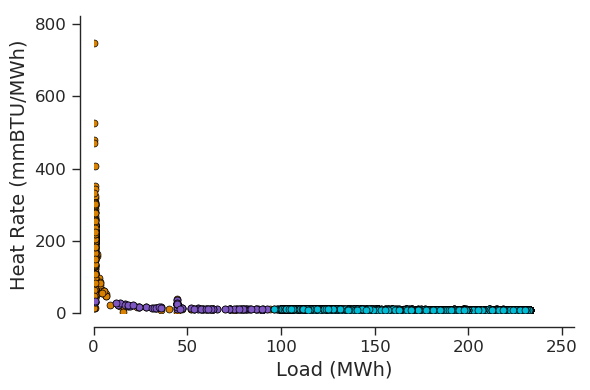

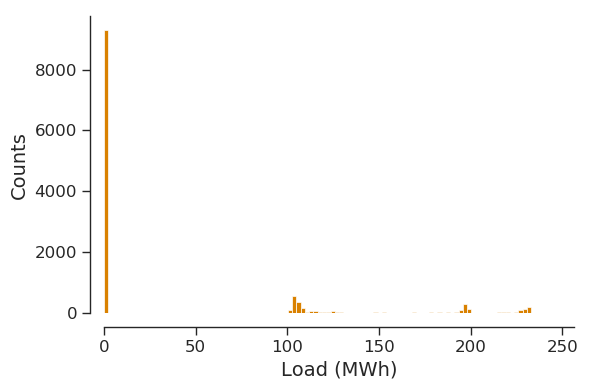

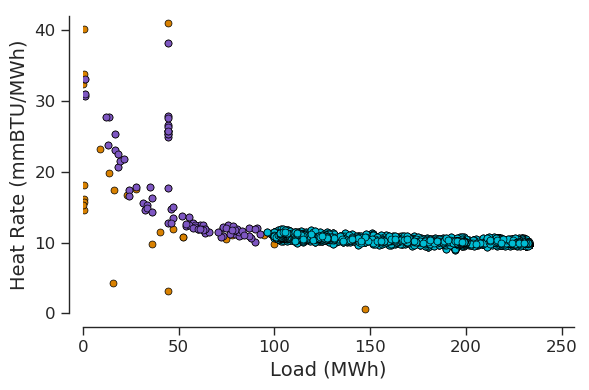

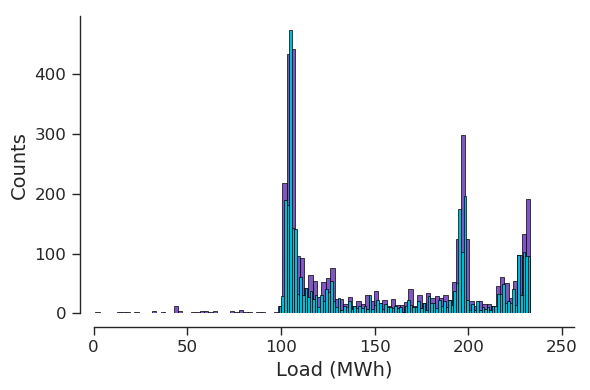

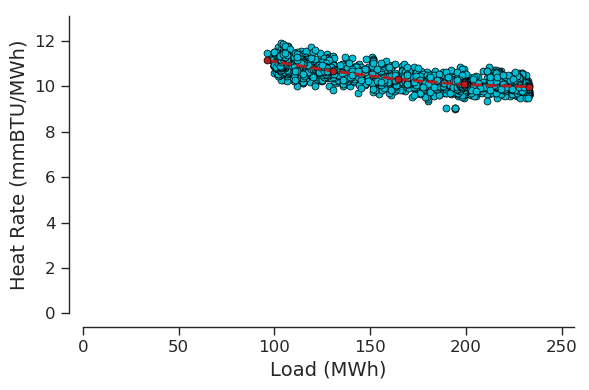

In [182]:
plt_units = []
unit_id = unit_ids[1]
plot_unit(unit_id, raw_df, filtered_df, group_fits, out_dir=None, title=title)

In [185]:
group_type = 'CT (NG)'
title = 
raw_df = analysis._get_raw(group_type)
filtered_df = analysis._get_filtered(group_type)
group_fits = analysis._get_fits(group_type)
unit_ids = ['1239_12', '120_CT5', '7834_CT2A', '1366_13', '1240_E3CT']

group_dir = os.path.join(fig_dir, group_type)
for unit_id in unit_ids:
    plot_unit(unit_id, raw_df, filtered_df, group_fits, out_dir=group_dir)

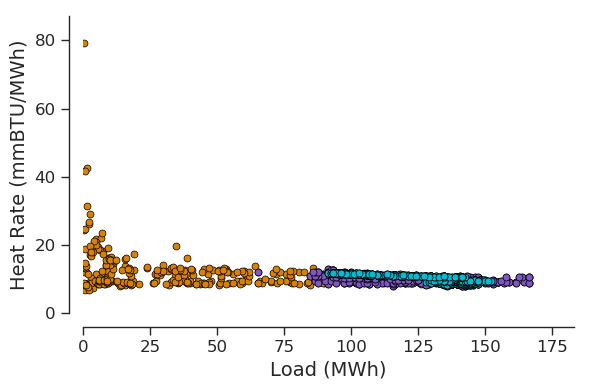

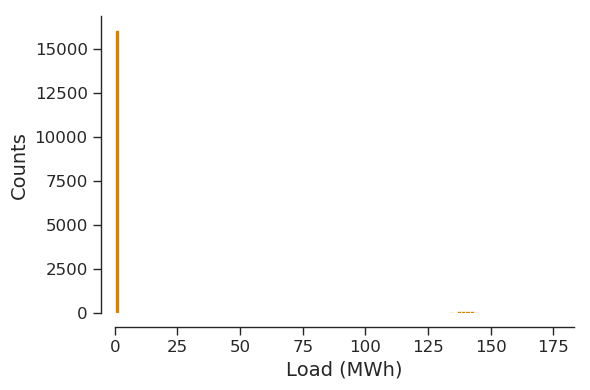

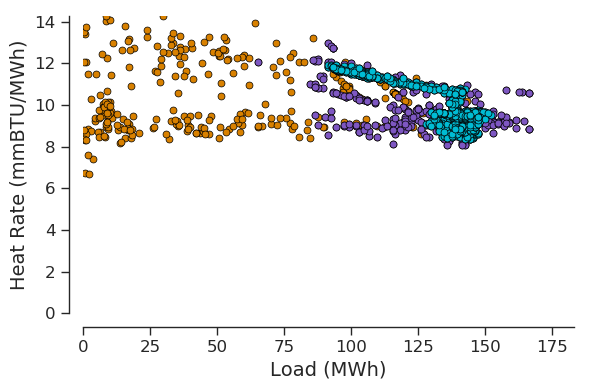

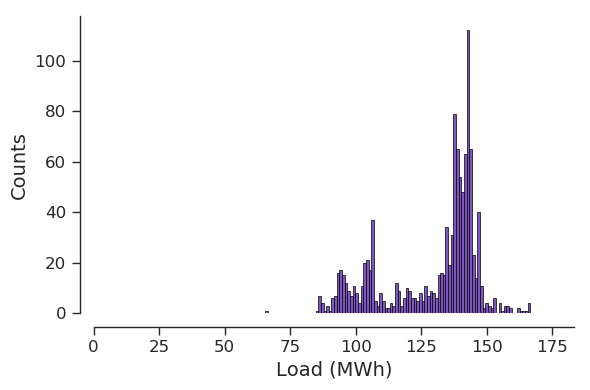

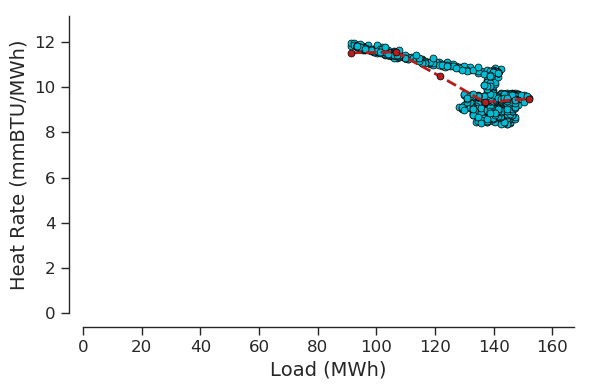

In [48]:
unit_id = unit_ids[3]
plot_unit(unit_id, raw_df, filtered_df, group_fits, out_dir=None)

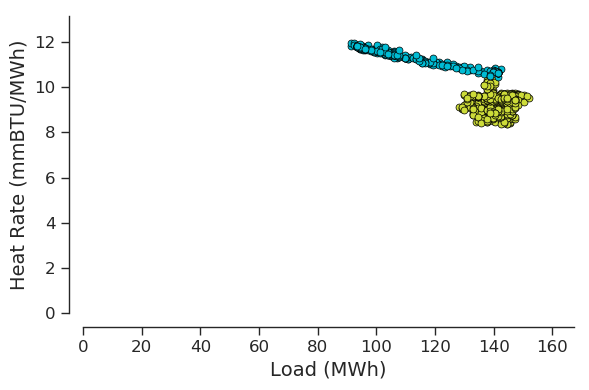

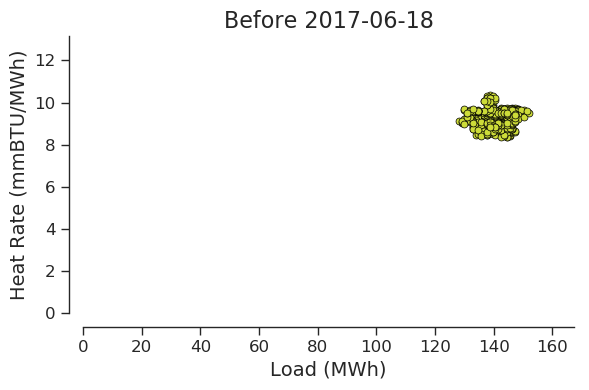

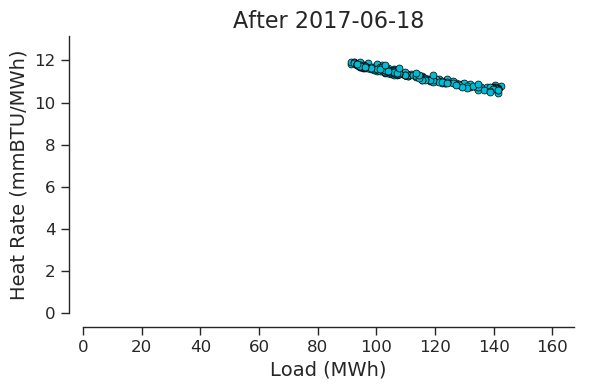

In [166]:
unit_id = '1366_13'
filtered_unit = filtered_df[unit_id]
filtered_unit.index = pd.to_datetime(filtered_unit['time'])
t = '2017-06-18'
split = pd.to_datetime(t)

pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos]
pos = final_unit.index > split
t1 = final_unit.loc[~pos, ['load', 'heat_rate']].values
t2 = final_unit.loc[pos, ['load', 'heat_rate']].values

x = final_unit['load'].values
x_lim = np.nanmax(x[x != np.inf]) * 1.1
y = final_unit['heat_rate'].values
y_lim = np.nanmax(y[y != np.inf]) * 1.1


mplt.line_plot(t1, t2, despine=True,
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('lime', 'cyan')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, x_lim), ylim=(0, y_lim),
              )

mplt.line_plot(t1, despine=True,
               title='Before {}'.format(t),
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('lime',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, x_lim), ylim=(0, y_lim),
              )

mplt.line_plot(t2, despine=True,
               title='After {}'.format(t),
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('cyan',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, x_lim), ylim=(0, y_lim),
              )

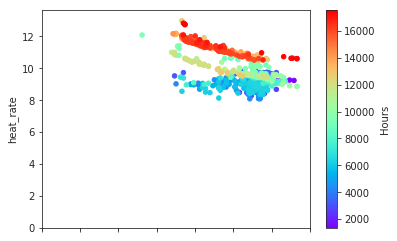

In [26]:
unit_id = '1366_13'
filtered_unit = filtered_df[unit_id]
filtered_unit['time'] = pd.to_datetime(filtered_unit['time'])
filtered_unit['Hours'] = (filtered_unit['time'] - pd.to_datetime('2016-01-01')).values * 2.77778e-13
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos]

filtered_unit.plot.scatter(x='load', y='heat_rate', c='Hours',
                   colormap='rainbow',
                   xlim=(0, filtered_unit['load'].max() * 1.05),
                   ylim=(0, filtered_unit['heat_rate'].max() * 1.05))
plt.show()

In [186]:
group_type = 'CC (NG)'
raw_df = analysis._get_raw(group_type)
filtered_df = analysis._get_filtered(group_type)
group_fits = analysis._fits[group_type]
group_fits['cc_unit'] = group_fits['unit_id'].str.split('-').str[0]
unit_ids = ['201_FIT1', '10190_CCCC', '1403_PB01', '55411_CC1', '8000_CC1', 
            '10308_CC1', '7999_CC01', '55306_BL04', '1007_CC1']

group_dir = os.path.join(fig_dir, group_type)
for unit_id in unit_ids:
    plot_CC(unit_id, raw_df, filtered_df, group_fits, out_dir=group_dir)

In [7]:
good_fits = group_fits.loc[~group_fits['a0'].isnull()]
cts = good_fits.groupby('cc_unit').size()
cts.unique()

array([ 2,  1,  4,  5,  3,  9,  7,  6, 13,  8])

In [9]:
cts.loc[cts == 3]

cc_unit
117_CC2       3
1927_RIV0     3
2406_CC2      3
260_CC2       3
2720_CC1      3
330_7         3
399_CC1       3
3_G521        3
3_G522        3
50966_G781    3
52019_UNT5    3
54832_F701    3
55048_1226    3
55103_CC1     3
55129_STG3    3
55139_BLK1    3
55153_STG1    3
55182_CC1     3
55188_CC1     3
55193_CC01    3
55215_BLK1    3
55217_CC1     3
55242_CC1     3
55283_CC1     3
55298_BLK1    3
55298_BLK2    3
55322_PB1     3
55350_CC1     3
55357_STG1    3
55382_1       3
             ..
55661_CC1     3
55662_CC1     3
55714_MC1     3
55835_RKM0    3
55965_G106    3
55965_G107    3
55977_CC1     3
56041_MGS     3
56046_CC1     3
56150_G111    3
56188_CC1     3
56237_CC2     3
56467_CC1     3
564_OUC       3
56610_CCU1    3
56807_CC1     3
56963_700     3
58001_TMP1    3
58001_TMP2    3
58005_CC1     3
6043_C796     3
643_G180      3
7082_PB1      3
710_G106      3
7350_CC1      3
7604_2        3
7805_2        3
7845_CC1      3
8000_CC1      3
8031_G821     3
Length: 64, dtyp

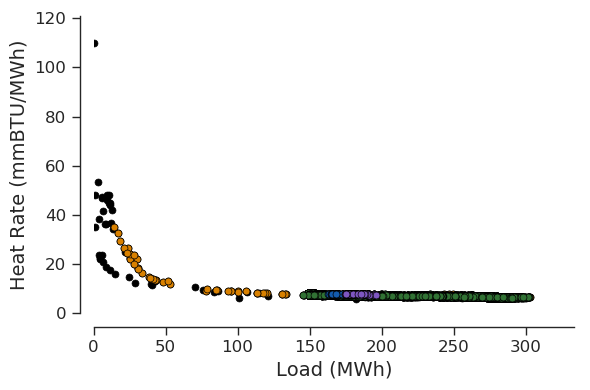

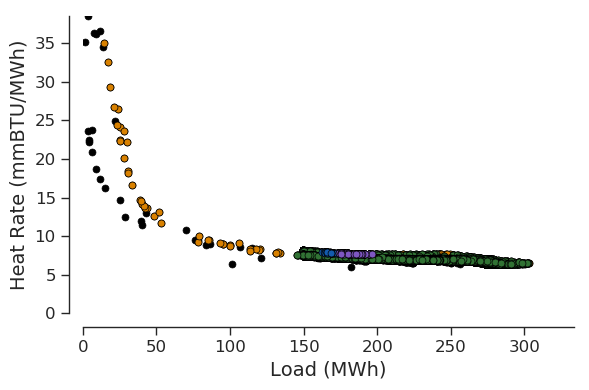

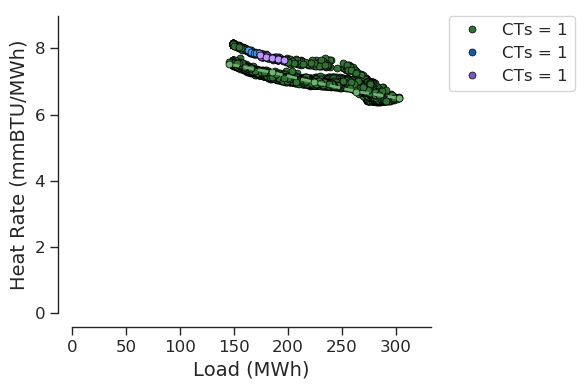

In [136]:
unit_id = unit_ids[3]
unit_id = '564_OUC'

plot_CC(unit_id, raw_df, filtered_df, group_fits, out_dir=None)

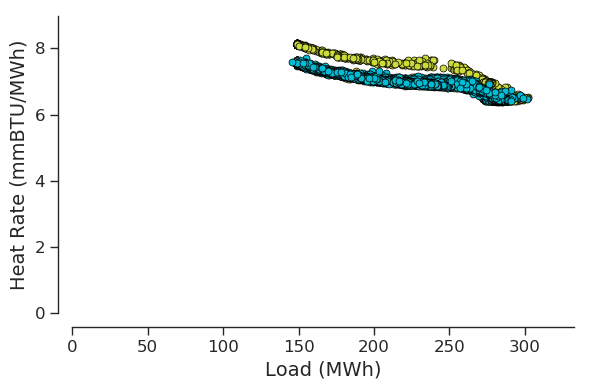

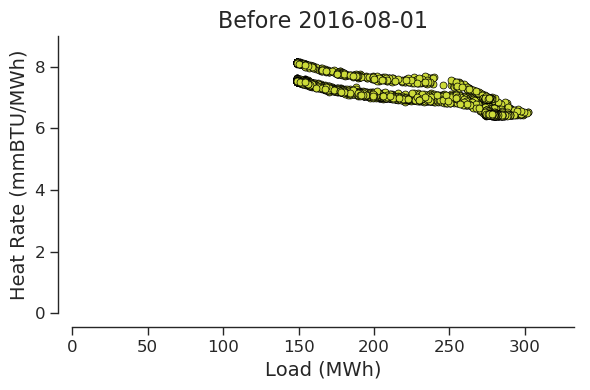

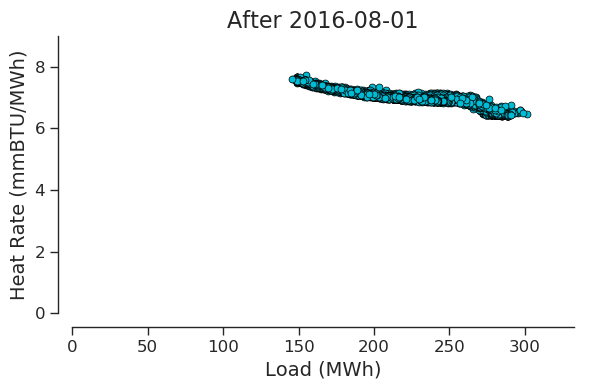

In [169]:
unit_id = '564_OUC'
filtered_unit = filtered_df[unit_id]
filtered_unit.index = pd.to_datetime(filtered_unit['time'])
t = '2016-08-01'
split = pd.to_datetime(t)

pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos]
pos = final_unit.index > split
t1 = final_unit.loc[~pos, ['load', 'heat_rate']].values
t2 = final_unit.loc[pos, ['load', 'heat_rate']].values

x = final_unit['load'].values
x_lim = np.nanmax(x[x != np.inf]) * 1.1
y = final_unit['heat_rate'].values
y_lim = np.nanmax(y[y != np.inf]) * 1.1


mplt.line_plot(t1, t2, despine=True,
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('lime', 'cyan')),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, x_lim), ylim=(0, y_lim),
              )

mplt.line_plot(t1, despine=True,
               title='Before {}'.format(t),
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('lime',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, x_lim), ylim=(0, y_lim),
              )

mplt.line_plot(t2, despine=True,
               title='After {}'.format(t),
               linestyles=('',), markers=('o',),
               colors=mplt.get_COLORS(('cyan',)),
               xlabel='Load (MWh)', ylabel='Heat Rate (mmBTU/MWh)',
               xlim=(0, x_lim), ylim=(0, y_lim),
              )

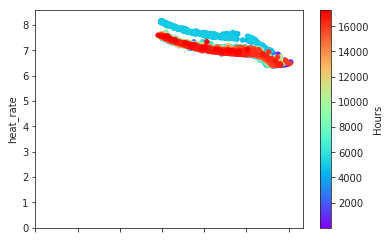

In [149]:
unit_id = '564_OUC'
filtered_unit = filtered_df[unit_id]
filtered_unit['time'] = pd.to_datetime(filtered_unit['time'])
filtered_unit['Hours'] = (filtered_unit['time'] - pd.to_datetime('2016-01-01')).values * 2.77778e-13
pos = filtered_unit['cluster'] >= 0
final_unit = filtered_unit.loc[pos]

final_unit.plot.scatter(x='load', y='heat_rate', c='Hours',
                   colormap='rainbow',
                   xlim=(0, final_unit['load'].max() * 1.05),
                   ylim=(0, final_unit['heat_rate'].max() * 1.05))
plt.show()